In [1]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB
from datetime import datetime

In [2]:
# 사후정산 모듈
src = ['서울역']
dst = ['노원역','안암역','한양대역']
order = ['안암역','한양대역','노원역']
total_pay = 34200
# time = "2023-07-06T23:30:00+0900"

In [3]:
# order있으면 순서대로 배치
if order:
    src.extend(order)
else:
    src.extend(dst)

routing = src

loc_info = {i :[src[i]] for i in range(len(src))}
loc_info

{0: ['서울역'], 1: ['안암역'], 2: ['한양대역'], 3: ['노원역']}

In [4]:
# 출발지+도착지 좌표
for i in range(len(loc_info)):
    url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchType=all" \
          f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

    headers = {
        "Accept": "application/json",
        "appKey": "l7xxcdd1a30a6b34450a881f8083994a8cd4"
    }

    response = requests.get(url, headers=headers)
    jsonObj = json.loads(response.text)
    loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
    loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))

loc_info

{0: ['서울역', 126.96921669, 37.55320558],
 1: ['안암역', 127.02934916, 37.58631392],
 2: ['한양대역', 127.04368209, 37.55462342],
 3: ['노원역', 127.06042771, 37.65486207]}

In [5]:
addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
addr_info

{'서울역': {'no': 0, 'lon': 126.96921669, 'lat': 37.55320558},
 '안암역': {'no': 1, 'lon': 127.02934916, 'lat': 37.58631392},
 '한양대역': {'no': 2, 'lon': 127.04368209, 'lat': 37.55462342},
 '노원역': {'no': 3, 'lon': 127.06042771, 'lat': 37.65486207}}

dict_keys(['서울역', '안암역', '한양대역', '노원역'])


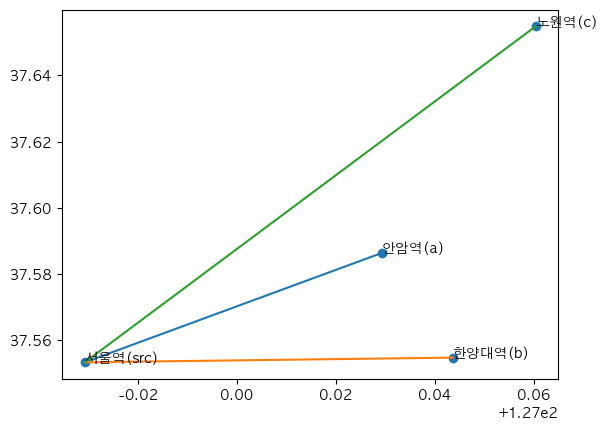

In [6]:
# 직선거리 시각화
passenger_sample = addr_info.keys()
print(passenger_sample)
src,a,b,c = passenger_sample
pass_2_node = {'src': src, 'a': a, 'b': b, 'c': c}
node_2_pass = {src: 'src', a: 'a', b: 'b', c: 'c'}

lat = [addr_info[addr]['lat'] for addr in passenger_sample]
lon = [addr_info[addr]['lon'] for addr in passenger_sample]
addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))

for i, txt in enumerate(addr):
    try:
        ax.plot([lon[0], lon[i+1]], [lat[0], lat[i+1]])
    except: pass


plt.show()

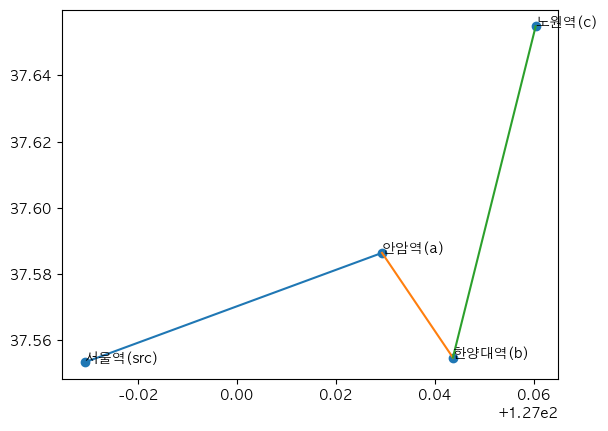

['서울역', '안암역', '한양대역', '노원역']


In [7]:
lat2 = [addr_info[rou]['lat'] for rou in routing]
lon2 = [addr_info[rou]['lon'] for rou in routing]

# 경유거리 시각화
fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(routing):
    try:
        ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
    except: pass
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))
plt.show()

passenger_routing = routing
print(passenger_routing)


In [8]:
individual_distance = []
individual_duration = []
individual_cost = []


url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

# move alone 시간, 요금 계산
for i in range(len(loc_info)-1):
    payload = {
        "tollgateFareOption": 16,
        "roadType": 32,
        "directionOption": 1,
        
        # j번째 승객의 하차지역
        "endX": addr_info[passenger_routing[i+1]]['lon'],
        "endY": addr_info[passenger_routing[i+1]]['lat'],
        ##
        "endRpFlag": "G",
        "reqCoordType": "WGS84GEO",
        
        # 출발지역
        "startX": addr_info[passenger_routing[0]]['lon'],
        "startY": addr_info[passenger_routing[0]]['lat'],
        ##
        "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
        # "speed": 24, # 서울시 자동차 통행 속도
        "uncetaintyP": 1,
        "uncetaintyA": 1,
        "uncetaintyAP": 1,
        "carType": 0,
        "detailPosFlag": "2",
        "resCoordType": "WGS84GEO",
        "sort": "index",
        "searchOption": 0,
        "totalValue": 2,
        "trafficInfo": "Y", # 현재교통상황 반영
        "mainRoadInfo": "N"
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
    }

    response = requests.post(url, json=payload, headers=headers)
    jsonObj = json.loads(response.text)

    individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
    individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
    individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

In [9]:
print(passenger_routing[1:])
print(individual_distance)
print(individual_duration)
print(individual_cost)

['안암역', '한양대역', '노원역']
[8543, 12160, 26369]
[2172, 2492, 3453]
[14100, 16400, 26000]


In [10]:
routing_distance = []
routing_duration = []
routing_cost = []

url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

for j in range(1,len(loc_info)):
    print('start')
    passlist = ''
    # 내리는 순서에 따라 경유지 들리는 횟수가 달라진다. >> 경유지 설정
    for i in range(1,j+1):
        if i==j:
            break
        passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
        if i!=j-1:
            passlist += '_'
    ###

    payload = {
        "tollgateFareOption": 16,
        "roadType": 32,
        "directionOption": 1,

        # j번째 승객의 하차지역
        "endX": addr_info[passenger_routing[j]]['lon'],
        "endY": addr_info[passenger_routing[j]]['lat'],
        ###

        "endRpFlag": "G",
        "reqCoordType": "WGS84GEO",
        # 출발지역
        "startX": addr_info[passenger_routing[0]]['lon'],
        "startY": addr_info[passenger_routing[0]]['lat'],
        ###

        "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
        # "speed": 24,
        "uncetaintyP": 1,
        "uncetaintyA": 1,
        "uncetaintyAP": 1,
        "carType": 0,
        "detailPosFlag": "2",
        "resCoordType": "WGS84GEO",
        "sort": "index",
        "mainRoadInfo": "N",
        "trafficInfo": "Y", # 현재교통상황 반영
        "totalValue": 2
    }
    # passlist 없다면 pass
    if passlist!='':
        payload["passList"] = passlist
        ##
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "appKey": "l7xxcdd1a30a6b34450a881f8083994a8cd4"
        }
        print(passlist)
        response = requests.post(url, json=payload, headers=headers)
        jsonObj = json.loads(response.text)

        routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
        routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
        routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])
    else: pass
    print('end')

# 첫번째 하차 승객 정보 추가
routing_distance.insert(0,individual_distance[0])
routing_duration.insert(0,individual_duration[0])
routing_cost.insert(0,individual_cost[0])

start
end
start
127.02934916,37.58631392
end
start
127.02934916,37.58631392_127.04368209,37.55462342
end


In [11]:
print(passenger_routing[1:])
print(individual_duration)
print(routing_duration)
print(routing_cost)
routing_cost = [int(x/max(routing_cost)*total_pay) for x in routing_cost]
print(routing_cost)

['안암역', '한양대역', '노원역']
[2172, 2492, 3453]
[2172, 3228, 5664]
[14100, 19800, 38300]
[12590, 17680, 34200]


In [12]:
# 지연 비율 >> 요금 정산에 필요
delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]
delay_ratio

[0.0, 0.2953451043338684, 0.6403127715030409]

In [13]:
I1, I2, I3 = individual_cost
R1, R2, R3 = delay_ratio
T = routing_cost[-1]
eplison = 0 # 실제요금과 예상요금의 차이
gamma = 0 # 혹시수익

LB = 0.4
UB = 0.8

## matching ALGorithm
try:
  # Create a new model
  m = gp.Model('cost_optimization1')
  m.Params.LogToConsole = 0

  # Create variables
  alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
  beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

  # Set objective
  m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T, GRB.MINIMIZE)

  # Add constraint
  m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
  m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
  m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T >= 0,'const_3')

  m.addConstr(alpha <= 1)
  m.addConstr(alpha >= 0)
  m.addConstr(beta <= 1)
  m.addConstr(beta >= 0)
  #m.addConstr(gamma <= 1)

  # Optimize model
  m.optimize()

  for v in m.getVars():
    print('%s : %g' % (v.varName, v.x))
    globals()[v.varName] = v.x
  print(alpha)

except gp.GurobiError as e:
  print('Error code ' + str(e.errno) + ': ' + str(e))

Restricted license - for non-production use only - expires 2024-10-28
alpha : 0.318909
beta : 0.199221
0.3189094334352046


In [14]:
print(f'A {alpha*100:.2f}+{beta*R1*100:.2f} => {(alpha+beta*R1)*100:.2f}% 할인')
print(f'B {alpha*100:.2f}+{beta*R2*100:.2f} => {(alpha+beta*R2)*100:.2f}% 할인')
print(f'C {alpha*100:.2f}+{beta*R3*100:.2f} => {(alpha+beta*R3)*100:.2f}% 할인')
print()
print(f'A {I1} 원 >>> {int((1-alpha-beta*R1)*I1)} 원')
print(f'B {I2} 원 >>> {int((1-alpha-beta*R2)*I2)} 원')
print(f'C {I3} 원 >>> {int((1-alpha-beta*R3)*I3)} 원')

routing_individual_cost = [int((1-alpha-beta*R1)*I1),int((1-alpha-beta*R2)*I2),int((1-alpha-beta*R3)*I3)]

A 31.89+0.00 => 31.89% 할인
B 31.89+5.88 => 37.77% 할인
C 31.89+12.76 => 44.65% 할인

A 14100 원 >>> 9603 원
B 16400 원 >>> 10204 원
C 26000 원 >>> 14391 원


In [15]:
T-sum(routing_individual_cost)

2